# Exploratory data analysis

In [2]:
import pandas as pd
import numpy as np

In [3]:
train_df = pd.read_csv('../data/train.csv')
train_df.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1


In [6]:
# number of unique values per variable
train_df.apply(lambda col: col.nunique())

genre_id              2922
ts_listen          2256230
media_id            452975
album_id            151471
context_type            74
release_date          8902
platform_name            3
platform_family          3
media_duration        1652
listen_type              2
user_gender              2
user_id              19918
artist_id            67142
user_age                13
is_listened              2
dtype: int64


## Data & variable descriptions (from [kaggle](https://www.kaggle.com/competitions/dsg17-online-phase/data))

- File descriptions

    - train.csv - the training set
    - test.csv - the test set
    - sample_submission_kaggle.csv - a sample submission file in the correct format
    - extra_infos.json - supplementary information about the songs
<br>
<br>
- Data fields

    - media_id - identifiant of the song listened by the user
    - album_id - identifiant of the album of the song
    - media_duration - duration of the song
    - user_gender -  gender of the user
    - user_id -  anonymized id of the user
    - context_type - type of content where the song was listened: playlist, album ...
    - release_date - release date of the song with the format YYYYMMDD
    - ts_listen - timestamp of the listening in UNIX time
    - platform_name - type of os
    - platform_family - type of device
    - user_age - age of the user
    - listen_type - if the songs was listened in a flow or not
    - artist_id - identifiant of the artist of the song
    - genre_id - identifiant of the genre of the song
    - is_listened - 1 if the track was listened, 0 otherwise

In [27]:
# check balance of dataset with respect to flow and listened to
pd.crosstab(train_df.is_listened, train_df.listen_type).apply(lambda r: r/len(train_df), axis=1)

listen_type,0,1
is_listened,,
0,0.193304,0.122663
1,0.499822,0.184211


Seems like most songs were not implemented in a flow and listened to; about 70% of the songs were listened to and 30% not, and 70% were not presented in a flow.

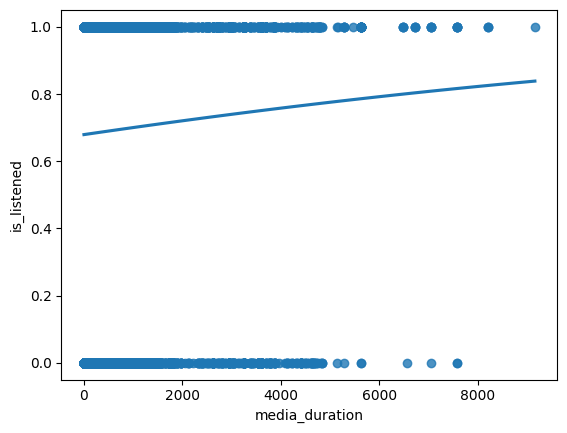

In [4]:
# !pip install statsmodels
import seaborn as sns

# filter song ~= 50'000
train_df_filt = train_df[train_df['media_duration'] < 50000]

def display_predictors(var):

    x  = train_df_filt[f'{var}']
    y  = train_df_filt['is_listened']
    sns.regplot(x=x, y=y, data=train_df, logistic=True, ci=None)


display_predictors('media_duration')


In [6]:
# check other variables
#display_predictors('user_age')

In [ ]:
# display histograms and bar charts with plotly